Magnetic Vector Inversion - Demo 
==================

**Objective**

In this tutorial we will invert a synthetic magnetic problem using the SimPEG framework.

We are using the integral form of the magnetostatic problem. In the absence of free-currents or changing magnetic field, magnetic material can give rise to a secondary magnetic field according to:

$$\vec b = \frac{\mu_0}{4\pi}  \int_{V}   \vec M \cdot \nabla \nabla \left(\frac{1}{r}\right) \; dV $$

Where $\mu_0$ is the magnetic permealitity of free-space, $\vec M$ is the magnetization per unit volume and $r$  defines the distance between the observed field $\vec b$ and the magnetized object. The strenght of magnetization can be written as:

$$ \vec M = \mu_0 \kappa ( \vec H_0 + \vec H_s ) + \vec M_r $$

where $\kappa$ the magnetic susceptibility of matter, $\vec H_0$ is Earth's inducing field, $\vec H_s$ are secondary fields from surrounding bodies (also refered to as self-demagnetization) and $\vec M_r$ is the remanent component.

As derived by Sharma 1966, the integral can be evaluated for rectangular prisms such that:

$$ \vec b(P) =  \mathbf{T} \cdot \vec M $$

Where the tensor matrix $\bf{T}$ relates the three components of magnetization $\vec M$ to the components of the field $\vec b$:

$$\mathbf{T} =
	 \begin{pmatrix}
       		T_{xx} & T_{xy} & T_{xz}    \\
		T_{yx} & T_{yy} & T_{yz}    \\
		T_{zx} & T_{zy} & T_{zz}           
	\end{pmatrix} $$
    
In general, we discretize the earth into a collection of cells, each contributing to the magnetic data such that:

$$\vec b(P) = \sum_{j=1}^{nc} \mathbf{T}_j \cdot \vec M_j$$

giving rise to a linear problem.


In [1]:
# Load the various libraries
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, DataMisfit, Inversion, Utils, Regularization
import SimPEG.PF as PF
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


Data
==

First we need to load some mag data.

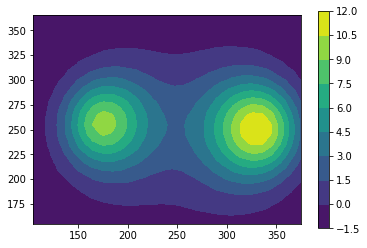

In [2]:
# Load some data in x,y,z,data(nT)
dataMat = np.loadtxt('.\Synthetic\Obs_loc_TMI.obs')
xyzLoc = dataMat[:,:3]
data = dataMat[:,3]

# The data was simulated with a simple vertical inducing field. 
# This only matters for the data projection.
H = [50000, 90 , 0] # Strenght (nT), Inc (deg), Dec (deg)

# We can create a SimPEG.Survey, which contains all the necessary information needed for the inversion


rx = PF.BaseMag.RxObs(xyzLoc)
srcField = PF.BaseMag.SrcField([rx], param=H)
survey = PF.BaseMag.LinearSurvey(srcField)
survey.dobs = data


# We can plot the data, looks like this
# We can now generate data
#data = F.dot(model)  #: this is matrix multiplication!!
# fig, im = PF.Magnetics.plot_obs_2D(survey.srcField.rxList[0].locs, d=survey.dobs, title='Observed data', cmap="RdBu_r")
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()
im = Utils.PlotUtils.plot2Ddata(survey.srcField.rxList[0].locs, survey.dobs)
plt.colorbar(im[0])

Data Uncertainties
==========

We also need to assign uncertainties on the data. We will minimize the normalized residual of the form:

$$ \phi_d = \| \mathbf{W}_d (\mathbf{d}^{pre} - \mathbf{d}^{obs}\|_2 $$

where $\mathbf{W}_d$ is a diagonal matrix containing the standard deviations.

Estimating the data uncertainties is always hard, but usually best to start with a concervative number (large) and slowly reduce them until all the signal is captured by the inversion. 
Here I know exactly how much random noise I added (0.1 nT). 
Usually much larger than this (>10nT), but up to the user to experiment.

In [3]:
survey.std = np.ones(survey.nD) * 0.1

Topography
======
We also need the topography which will determine the boundary between air and ground

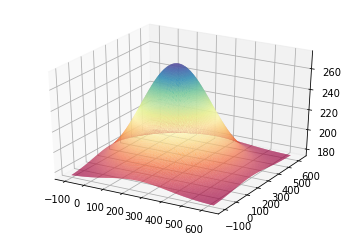

In [4]:
# Load a scatter xyz data points 
topo = np.loadtxt('.\Synthetic\Gaussian.topo')

# Here how the topo looks with a quick interpolation, just a Gaussian...
tri = sp.spatial.Delaunay(topo)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(topo[:,0], topo[:,1], topo[:,2], triangles=tri.simplices, cmap=plt.cm.Spectral)
plt.show()

**Mesh**
=====
Now we need a mesh to invert physical properties on. 
I provided a mesh in the same folder, but generally you won't have one.
It is a tradeoff between having a very large problem to solve (too small cells) versus resolution (too coarse). Usually recommended to have 1 or 2 cells between each survey lines.

We created a small utility to generate a mesh based on the core cell dimension and padding distance. Use at your own risk ;)

In [5]:
def meshBuilder(xyz, h, padDist, meshGlobal=None,
                expFact=1.3,
                meshType='TENSOR',
                verticalAlignment='top'):
    """
        Function to quickly generate a Tensor mesh
        given a cloud of xyz points, finest core cell size
        and padding distance.
        If a meshGlobal is provided, the core cells will be centered
        on the underlaying mesh to reduce interpolation errors.

        :param numpy.ndarray xyz: n x 3 array of locations [x, y, z]
        :param numpy.ndarray h: 1 x 3 cell size for the core mesh
        :param numpy.ndarray padDist: 2 x 3 padding distances [W,E,S,N,Down,Up]
        [OPTIONAL]
        :param numpy.ndarray padCore: Number of core cells around the xyz locs
        :object SimPEG.Mesh: Base mesh used to shift the new mesh for overlap
        :param float expFact: Expension factor for padding cells [1.3]
        :param string meshType: Specify output mesh type: "TensorMesh"

        RETURNS:
        :object SimPEG.Mesh: Mesh object

    """

    assert meshType in ['TENSOR', 'TREE'], ('Revise meshType. Only ' +
                                            ' TENSOR | TREE mesh ' +
                                            'are implemented')

    # Get extent of points
    limx = np.r_[xyz[:, 0].max(), xyz[:, 0].min()]
    limy = np.r_[xyz[:, 1].max(), xyz[:, 1].min()]
    limz = np.r_[xyz[:, 2].max(), xyz[:, 2].min()]

    # Get center of the mesh
    midX = np.mean(limx)
    midY = np.mean(limy)
    midZ = np.mean(limz)

    nCx = int(limx[0]-limx[1]) / h[0]
    nCy = int(limy[0]-limy[1]) / h[1]
    nCz = int(limz[0]-limz[1]+int(np.min(np.r_[nCx, nCy])/3)) / h[2]

    if meshType == 'TENSOR':
        # Make sure the core has odd number of cells for centereing
        # on global mesh
        if meshGlobal is not None:
            nCx += 1 - int(nCx % 2)
            nCy += 1 - int(nCy % 2)
            nCz += 1 - int(nCz % 2)

        # Figure out paddings
        def expand(dx, pad):
            L = 0
            nC = 0
            while L < pad:
                nC += 1
                L = np.sum(dx * expFact**(np.asarray(range(nC))+1))

            return nC

        # Figure number of padding cells required to fill the space
        npadEast = expand(h[0], padDist[0, 0])
        npadWest = expand(h[0], padDist[0, 1])
        npadSouth = expand(h[1], padDist[1, 0])
        npadNorth = expand(h[1], padDist[1, 1])
        npadDown = expand(h[2], padDist[2, 0])
        npadUp = expand(h[2], padDist[2, 1])

        # Create discretization
        hx = [(h[0], npadWest, -expFact),
              (h[0], nCx),
              (h[0], npadEast, expFact)]
        hy = [(h[1], npadSouth, -expFact),
              (h[1], nCy), (h[1],
              npadNorth, expFact)]
        hz = [(h[2], npadDown, -expFact),
              (h[2], nCz),
              (h[2], npadUp, expFact)]

        # Create mesh
        mesh = Mesh.TensorMesh([hx, hy, hz], 'CC0')

        # Re-set the mesh at the center of input locations
        # Set origin
        if verticalAlignment == 'center':
            mesh.x0 = [midX-np.sum(mesh.hx)/2., midY-np.sum(mesh.hy)/2., midZ-np.sum(mesh.hz)/2.]
        elif verticalAlignment == 'top':
            mesh.x0 = [midX-np.sum(mesh.hx)/2., midY-np.sum(mesh.hy)/2., limz[0]-np.sum(mesh.hz)]
        else:
            assert NotImplementedError("verticalAlignment must be 'center' | 'top'")

    elif meshType == 'TREE':

        # Figure out full extent required from input
        extent = np.max(np.r_[nCx * h[0] + padDist[0, :].sum(),
                              nCy * h[1] + padDist[1, :].sum(),
                              nCz * h[2] + padDist[2, :].sum()])

        maxLevel = int(np.log2(extent/h[0]))+1

        # Number of cells at the small octree level
        # For now equal in 3D

        nCx, nCy, nCz = 2**(maxLevel), 2**(maxLevel), 2**(maxLevel)
        # nCy = 2**(int(np.log2(extent/h[1]))+1)
        # nCz = 2**(int(np.log2(extent/h[2]))+1)

        # Define the mesh and origin
        # For now cubic cells
        mesh = Mesh.TreeMesh([np.ones(nCx)*h[0],
                              np.ones(nCx)*h[1],
                              np.ones(nCx)*h[2]])

        # Set origin
        if verticalAlignment == 'center':
            mesh.x0 = np.r_[-nCx*h[0]/2.+midX, -nCy*h[1]/2.+midY, -nCz*h[2]/2.+midZ]
        elif verticalAlignment == 'top':
            mesh.x0 = np.r_[-nCx*h[0]/2.+midX, -nCy*h[1]/2.+midY, -(nCz-1)*h[2] + limz.max()]
        else:
            assert NotImplementedError("verticalAlignment must be 'center' | 'top'")

    return mesh


def refineTree(mesh, xyz, finalize=False, dtype="point", nCpad=[1, 1, 1]):

    maxLevel = int(np.log2(mesh.hx.shape[0]))

    if dtype == "point":

        mesh.insert_cells(xyz, np.ones(xyz.shape[0])*maxLevel, finalize=False)

        stencil = np.r_[
                np.ones(nCpad[0]),
                np.ones(nCpad[1])*2,
                np.ones(nCpad[2])*3
            ]

        # Reflect in the opposite direction
        vec = np.r_[stencil[::-1], 1, stencil]
        vecX, vecY, vecZ = np.meshgrid(vec, vec, vec)
        gridLevel = np.maximum(np.maximum(vecX,
                               vecY), vecZ)
        gridLevel = np.kron(np.ones((xyz.shape[0], 1)), gridLevel)

        # Grid the coordinates
        vec = np.r_[-stencil[::-1], 0, stencil]
        vecX, vecY, vecZ = np.meshgrid(vec, vec, vec)
        offset = np.c_[
            mkvc(np.sign(vecX)*2**np.abs(vecX) * mesh.hx.min()),
            mkvc(np.sign(vecY)*2**np.abs(vecY) * mesh.hx.min()),
            mkvc(np.sign(vecZ)*2**np.abs(vecZ) * mesh.hx.min())
        ]

        # Replicate the point locations in each offseted grid points
        newLoc = (
            np.kron(xyz, np.ones((offset.shape[0], 1))) +
            np.kron(np.ones((xyz.shape[0], 1)), offset)
        )

        mesh.insert_cells(
            newLoc, maxLevel-mkvc(gridLevel)+1, finalize=finalize
        )

    elif dtype == 'surface':

        # Get extent of points
        limx = np.r_[xyz[:, 0].max(), xyz[:, 0].min()]
        limy = np.r_[xyz[:, 1].max(), xyz[:, 1].min()]

        F = NearestNDInterpolator(xyz[:, :2], xyz[:, 2])
        zOffset = 0
        # Cycle through the first 3 octree levels
        for ii in range(3):

            dx = mesh.hx.min()*2**ii

            nCx = int((limx[0]-limx[1]) / dx)
            nCy = int((limy[0]-limy[1]) / dx)

            # Create a grid at the octree level in xy
            CCx, CCy = np.meshgrid(
                np.linspace(limx[1], limx[0], nCx),
                np.linspace(limy[1], limy[0], nCy)
            )

            z = F(mkvc(CCx), mkvc(CCy))

            # level means number of layers in current OcTree level
            for level in range(int(nCpad[ii])):

                mesh.insert_cells(
                    np.c_[mkvc(CCx), mkvc(CCy), z-zOffset], np.ones_like(z)*maxLevel-ii,
                    finalize=False
                )

                zOffset += dx

        if finalize:
            mesh.finalize()

    else:
        NotImplementedError("Only dtype='points' has been implemented")

    return mesh

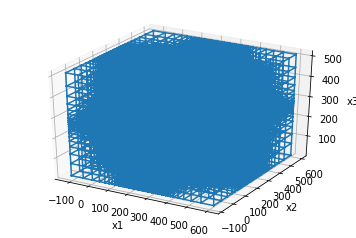

In [6]:
# I want 10 m cells in x, y and z covering our survey
h = np.r_[10., 10., 10.]

# Also need to paddout far enough in case there is a regional field
# Here I am sending distances N, S, E, W, above and below all at once
# Let's say 200 m padding
padDist = np.ones((3,2))*200.

mesh = meshBuilder(xyzLoc, h, padDist,
                   meshGlobal=None,
                   expFact=1.3,
                   meshType='TENSOR',
                   verticalAlignment='center')

# We can plot it to see
mesh.plotGrid()
plt.show()

# And save a copy on disk for later use
Mesh.TensorMesh.writeUBC(mesh, 'TensorTest.msh')

Creating the forward Problem
================

Now that we have all our spatial components, we can create our linear system. For a single location and single component of the data, the system would looks like this:

$$ b_x =
	\begin{bmatrix}
	T_{xx}^1 &... &T_{xx}^{nc} & T_{xy}^1 & ... & T_{xy}^{nc} & T_{xz}^1 & ... & T_{xz}^{nc}\\
	 \end{bmatrix}
	 \begin{bmatrix}
		\mathbf{M}_x \\ \mathbf{M}_y \\ \mathbf{M}_z
	\end{bmatrix} \\ $$

where each of $T_{xx},\;T_{xy},\;T_{xz}$ are [nc x 1] long. For the $y$ and $z$ component, we need the two other rows of the tensor $\mathbf{T}$.
The magnetization direction $\mathbf{M_x,\;M_y\;,Mz}$ are unknown parameters that we want to invert for. Inside of writing in terms of magnetization, we can write it in terms of *effective susceptibility* along cartesian directions such that:

$$ {\mathbf{d}}^{\text{pred}} = H_0 \mathbf{T} \begin{bmatrix} \kappa_x \\ \kappa_y \\ \kappa_z \end{bmatrix}$$

In most geophysical surveys, we are not collecting all three components, but rather the magnitude of the field, or $Total\;Magnetic\;Intensity$ (TMI) data.
Because the inducing field is really large, we will assume that the anomalous fields are parallel to $\vec H_0$:

$$ d^{TMI}  = \hat H_0 \cdot \vec d$$

We then end up with a much smaller system:

$$ d^{TMI} = \mathbf{F\; \kappa_e}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.

In [7]:
# First we need to discretize the topo onto the mesh
# This function will assign 0:air, 1:ground
actv = Utils.modelutils.surface2ind_topo(mesh, topo, gridLoc='CC', method='nearest')
nC = int(np.sum(actv))

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=3*nC)

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap,
                                     actInd=actv, modelType='vector',
                                    parallelized=True)
# Pair the survey and problem
survey.pair(prob)


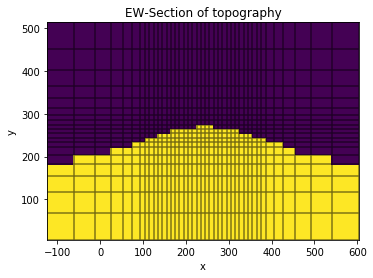

In [8]:

# We can check how the discretized topography looks
plt.figure()
ax = plt.subplot()
mesh.plotSlice(actv, ax = ax, normal = 'Y', ind=10, grid=True)
ax.set_title('EW-Section of topography')
ax.set_xlabel('x');ax.set_ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Looking good


Once we have our problem, we can use the inversion tools in SimPEG to run our inversion:

In [9]:
prob.G.shape

Begin forward: M=full, Rx type= tmi
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %


(616, 30672)

In [13]:

# This Mapping connects all the regularizations together
wires = Maps.Wires(('p', nC), ('s', nC), ('t', nC))

# Create sensitivity weights from our linear forward operator
# so that all cells get equal chance to contribute to the solution
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr/np.max(wr))


# Create three regularization for the different components
# of magnetization
reg_p = Regularization.Sparse(mesh, indActive=actv, mapping=wires.p)
reg_p.cell_weights = (wires.p * wr)
reg_p.mref = np.zeros(3*nC)

reg_s = Regularization.Sparse(mesh, indActive=actv, mapping=wires.s)
reg_s.cell_weights = (wires.s * wr)
reg_s.mref = np.zeros(3*nC)

reg_t = Regularization.Sparse(mesh, indActive=actv, mapping=wires.t)
reg_t.cell_weights = (wires.t * wr)
reg_t.mref = np.zeros(3*nC)

reg = reg_p + reg_s + reg_t
reg.mref = np.zeros(3*nC)

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# Choose a solver
opt = Optimization.ProjectedGNCG(maxIter=7, lower=-10., upper=10.,
                                 maxIterCG=20, tolCG=1e-3)

# The inverse problem needs to how the misfit, regularizer and solver
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

# Add directives to the inversion
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied usually
IRLS = Directives.Update_IRLS(f_min_change=1e-3,
                              minGNiter=1)

update_Jacobi = Directives.UpdatePreconditioner()
targetMisfit = Directives.TargetMisfit()
# MVIS = Directives.MagneticVectorSparse()

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, 0)
# saveModel = Directives.SaveUBCModelEveryIteration(mapping=actvMap)
# saveModel.fileName = 'MVI_C'

# Connect all the pieces together
inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi,
                                            ])

# Invert with a starting model
mstart = np.ones(3*nC) * 1e-4
mrec_MVI = inv.run(mstart)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.35e+12  3.14e+05  1.62e-06  1.54e+07    1.75e+03      0              
   1  4.68e+12  3.18e+05  3.29e-09  3.34e+05    1.75e+03      0              
   2  2.34e+12  2.74e+05  1.03e-08  2.98e+05    1.75e+03      0              
   3  1.17e+12  2.16e+05  2.84e-08  2.49e+05    1.75e+03      0   Skip BFGS  
   4  5.84e+11  1.52e+05  6.80e-08  1.91e+05    1.75e+03      0   Skip BFGS  
   5  2.92e+11  9.18e+04  1.41e-07  1.33e+05    1.75e+03      0   Skip BFGS  
   6  1.46e+11  4.66e+04  2.50e-07  8.32e+04   

View the model
========

Congratulation! You have inverted magnetic data.

Now the most interesting part, is to look at the result and assess.
The code should have exported three vector models on your disk:
- MVI_C_IND.fld # The induced part
- MVI_C_REM.fld # The non-induced part
- MVI_C_VEC.fld # Total magnetization

Each model is made up of 3-component vectors in each cell, which you can visualize pretty easily with the free [UBC-Meshtools](http://www.eos.ubc.ca/~rshekhtm/utilities/MeshTools3d.zip).

![alt text](ScreenGrap.png)

Just for simplicity, we can convert this vector model into an *amplitude* model.

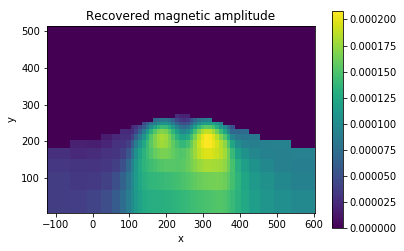

In [14]:
# Here is a quick way to convert your vector into a scalar
amp = np.sum(mrec_MVI.reshape((nC,3), order='F')**2., axis=1)**0.5

# We also need to map the model from ground-only to full mesh
actvMap = Maps.InjectActiveCells(mesh, actv, 0)
amp = actvMap * amp

# Et voila, now we can just slice it by changing the ind=#
plt.figure()
ax = plt.subplot()
im = mesh.plotSlice(amp, ax = ax, normal = 'Y', ind=20)
ax.set_title('Recovered magnetic amplitude')
ax.set_xlabel('x');ax.set_ylabel('y')
plt.colorbar(im[0])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Predicted data
========

Always very important after an inversion is to look at the data residual.

We want to make sure the inversion can actually predict the observed data, and maybe adjust the uncertainties if not satisfactory.

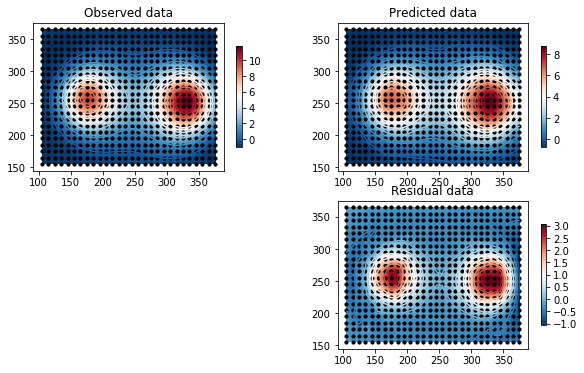

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
fig = plt.figure(figsize=(10,6))
ax1 = plt.subplot(2,2,1)
PF.Magnetics.plot_obs_2D(survey.srcField.rxList[0].locs, d=survey.dobs, ax= ax1, title='Observed data', cmap="RdBu_r")

# Predicted
ax2 = plt.subplot(2,2,2)
PF.Magnetics.plot_obs_2D(survey.srcField.rxList[0].locs, d=invProb.dpred, ax= ax2, title='Predicted data', cmap="RdBu_r")

# Residual
ax3 = plt.subplot(2,2,4)
PF.Magnetics.plot_obs_2D(survey.srcField.rxList[0].locs, d=survey.dobs-invProb.dpred, ax= ax3, title='Residual data', cmap="RdBu_r")

plt.show()

Hopefully you now have an idea of how to create a Problem class in SimPEG, and how this can be used with the other tools available.